In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
engine.execute('SELECT max(date) FROM measurement').fetchall()

[('2017-08-23',)]

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
last_12_mo_precip_data = session.query(measurement.date, measurement.prcp).filter(measurement.date >= "2016-08-24").\
    filter(measurement.date <= "2017-08-23").all()

In [12]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(last_12_mo_precip_data).set_index('date')
# Rename prcp column to precipitation
precip_df = precip_df.rename(columns={'prcp':'precipitation'})
# Sort the dataframe by date
precip_df = precip_df.sort_values(by='date', ascending=True).dropna()
precip_df.head()

,precipitation
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
2016-08-24,1.45


C:\Users\Robert Anthony\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


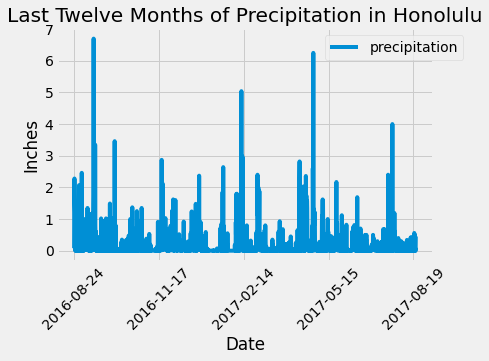

In [57]:
# Use Pandas Plotting with Matplotlib to plot the data

precip_df.plot(rot=45)
plt.ylabel('Inches')
plt.xlabel('Date')
plt.title('Last Twelve Months of Precipitation in Honolulu')
plt.legend('precipitation')
plt.legend(bbox_to_anchor=(1.10, 1))
plt.savefig('Images/precip_date.png', dpi=75, bbox_inches='tight')
plt.show()

In [58]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [83]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(station.id).count() 
station_count

9

In [91]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(measurement.station, func.count(measurement.station)).\
group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()

station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [98]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = 'USC00519281'
session.query(func.min(measurement.tobs),
        func.max(measurement.tobs),
        func.avg(measurement.tobs)).filter(measurement.station == most_active_station).all()

[(54.0, 85.0, 71.66378066378067)]

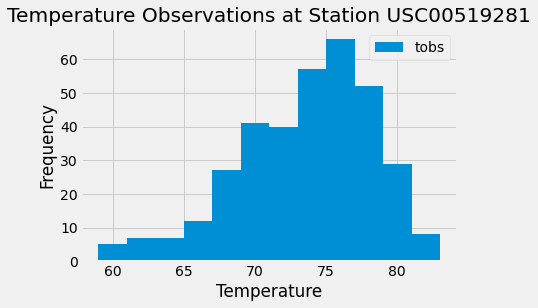

In [114]:
# Choose the station with the highest number of temperature observations.
highest_temp_obs_station = most_active_station
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obs = session.query(measurement.date, measurement.tobs).\
        filter(measurement.date >= "2016-08-24").\
        filter(measurement.date <= "2017-08-23").\
        filter(measurement.station == highest_temp_obs_station).all()
# Convert to DF
temp_obs_df = pd.DataFrame(temp_obs)
# Historgram
temp_obs_df.plot.hist(bins=12)
plt.title('Temperature Observations at Station USC00519281')
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.savefig('Images/Temp_Obs_Station.png', dpi=75, bbox_inches='tight')
plt.show()

In [16]:
session.close()

## Bonus Challenge Assignment

In [180]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [181]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2011-02-28', '2011-03-05'))
tmin, tavg, tmax = calc_temps('2011-02-28', '2011-03-05')[0]

[(61.0, 69.75510204081633, 75.0)]


<ipython-input-184-1734b0b8a71f>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


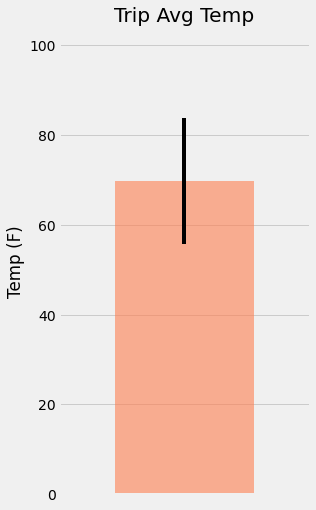

In [184]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=plt.figaspect(2.))
yerr = tmax-tmin
ax.bar(1, tavg, yerr=yerr, alpha=0.6, color='coral', align="center")
ax.set(xticks=range(1), title="Trip Avg Temp", ylabel="Temp (F)")
ax.margins(.4, .24)
plt.savefig('Images/Trip_Avg_Temp.png', dpi=75, bbox_inches='tight')
fig.show()

In [191]:
rainfall = session.query(station.station,  station.name, func.avg(measurement.prcp), station.latitude, station.longitude, station.elevation).\
        filter(station.station == measurement.station).\
        filter(measurement.date >= '2011-02-28').filter(measurement.date <= '2011-03-05').\
        group_by(measurement.station).order_by(func.avg(measurement.prcp).desc()).all()
rainfall

[('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  0.5825,
  21.4992,
  -158.0111,
  306.6),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  0.392,
  21.5213,
  -157.8374,
  7.0),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  0.37166666666666665,
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  0.365,
  21.33556,
  -157.71139,
  19.5),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  0.24166666666666667,
  21.3331,
  -157.8025,
  152.4),
 ('USC00513117', 'KANEOHE 838.1, HI US', 0.24, 21.4234, -157.8015, 14.6),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  0.22999999999999998,
  21.2716,
  -157.8168,
  3.0),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  0.126,
  21.3152,
  -157.9992,
  0.9),
 ('USC00517948', 'PEARL CITY, HI US', None, 21.3934, -157.9751, 11.9)]

In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0)]


In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


Text(9.310000000000002, 0.5, 'Temperature')

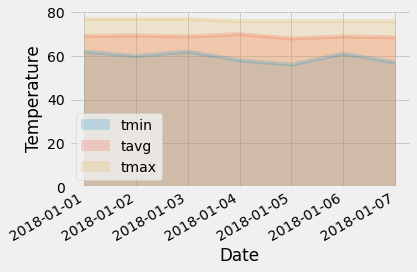

In [24]:
# Plot the daily normals as an area plot with `stacked=False`


In [ ]:
session.close()